# Ecological index - Regional decadal comparison of high value locations
- Plot 4 decades of AEV Index spatial plots
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Load data for eco index

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

In [7]:
# load siz data for masking

file_in = 'ecoindex_historical_future_masked_habitat.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

siz_cesm2le = ds_eco.siz_decadal

In [8]:
# load value bins

file_in = 'ecoindex_historical_future_bins.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

bins_cesm2le = ds_eco.aev_bins_region

In [9]:
# make an array with all bin values in it for differencing

# load the three bins, set missing values to zero
tmp1 = bins_cesm2le.isel(bin=0).fillna(0)
tmp2 = bins_cesm2le.isel(bin=1).fillna(0)
tmp3 = bins_cesm2le.isel(bin=2).fillna(0)

# for each of the three bins, re-label so that bin values are 1, 2, 3 and 0 is "other"
tmp1 = tmp1.where(tmp1 == 0, 3)
tmp2 = tmp2.where(tmp2 == 0, 2)

# add all three together
bins_all = tmp1 + tmp2 + tmp3

# mask by where we have data or not
bins_all = bins_all.where(ds_grid.REGION_MASK == 1)

In [10]:
# calculate differences in bins
bins_diff = bins_all - bins_all.sel(decades=2000)

# mask by where we have data or not
bins_diff = bins_diff.where(ds_grid.REGION_MASK == 1)

In [11]:
# mask inside and outside of SIZ for data

# mask individual bins
bins_all = bins_all.where(siz_cesm2le > 0)

# mask differences only by 2000s SIZ. Not later because it becomes smaller and we'll lose ability to see some changes
bins_diff = bins_diff.where(siz_cesm2le.sel(decades=2000) > 0)

### Load the typical polynya data

In [12]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [13]:
# Read in polynya data
file_in = 'CESM_grid_CESM2-LE_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_cesm2le = ds_poly.polynya_typical_all_hi

### Load regional masks

In [14]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [15]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


### Load Geography and MPA shapefiles

In [16]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [17]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

In [18]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [19]:
# Read in CCAMLR MPA files

# Adopted Ross Sea MPA
file_in = 'CCAMLR_MPAs/RossSea_no_ice_shelf/2015CCAMLR_RossSeaMore_102020.shp'
shdf_ross = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ross = shdf_ross.to_crs(ccrs.SouthPolarStereo())

# Adopted South Orkney Islands Shelf MPA
file_in = 'CCAMLR_MPAs/SOISS/MPA_2013.shp'
shdf_ork = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ork = shdf_ork.to_crs(ccrs.SouthPolarStereo())

# Proposed Weddell
file_in = 'CCAMLR_MPAs/WSMPA2019_Shapefile/WSMPA2019.shp'
shdf_wed = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_wed = shdf_wed.to_crs(ccrs.SouthPolarStereo())

# Proposed Weddell Phase 2
file_in = 'CCAMLR_MPAs/WSMPAP2_polygons_2024/ABCDEF.shp'
shdf_wed2 = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_wed2 = shdf_wed2.to_crs(ccrs.SouthPolarStereo())

# Proposed E. Antarctica
file_in = 'CCAMLR_MPAs/Earsmpa_2015_CCAMLR_XXXIV/Earsmpa_2015_CCAMLR_XXXIV.shp'
shdf_eant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_eant = shdf_eant.to_crs(ccrs.SouthPolarStereo())

# Proposed Peninsula
file_in = 'CCAMLR_MPAs/D1MPA_Vertices_2024_HS/D1MPA_Vertices_2024_HS_cut.shp'
shdf_pen = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_pen = shdf_pen.to_crs(ccrs.SouthPolarStereo())

## Plot figures

In [20]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'

In [21]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [22]:
# get lat/lon info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

### Set plotting ranges, colors, etc.

In [23]:
# set contour levels for polynyas
levels_in_ctr = np.arange(0,3,1)

In [24]:
from matplotlib import colors as c
cMap_bins = c.ListedColormap(['cornsilk','palegreen','limegreen','darkgreen'])
cMap_diff = c.ListedColormap(['midnightblue','royalblue','lightblue','lightgrey','lightpink','coral','firebrick'])

# look at colormap
#data = np.random.rand(10, 10) # A 10x10 array of random values
#plt.imshow(data, cmap=cMap_5)

In [25]:
# make arrays for the Amundsen/Peninsula region
lats_bound = np.arange(-73, -50, 1)
#lats_bound
lons_bound = np.linspace(275, 275, lats_bound.shape[0])
#lons_bound

### Plot AEV bins by decade
- 2000, 2030, 2060, 2090

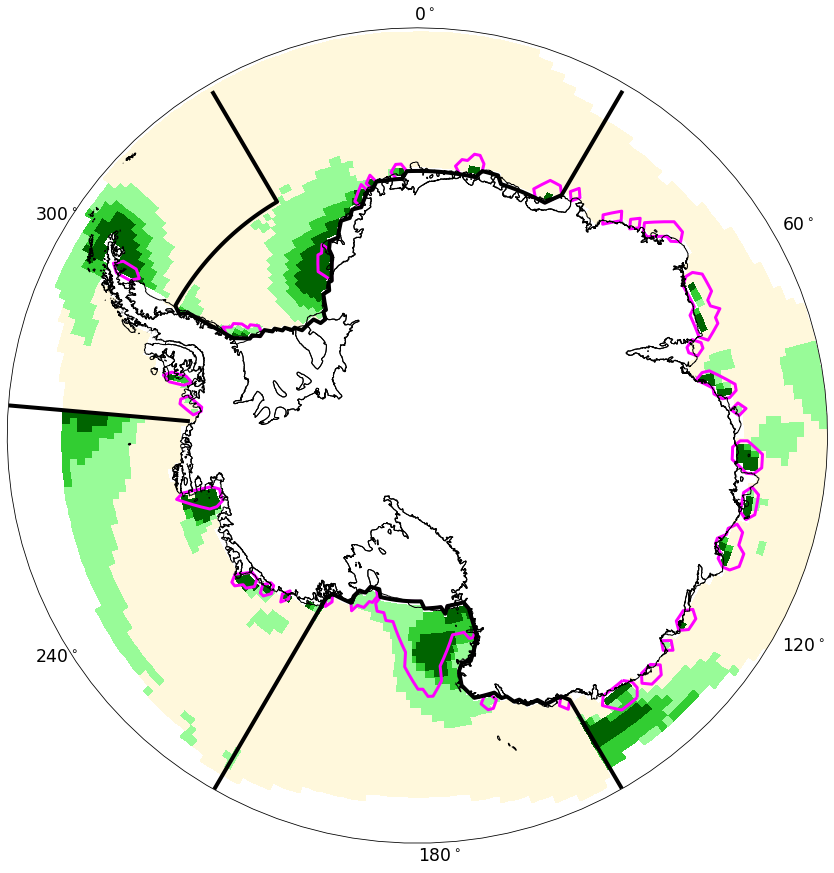

In [26]:
### Plot Regional AEV Index Bins by decade
# set decade to plot
dec = 2000
dec_str = str(dec)
fout = 'Figure_4_AEV_region_bins_'+dec_str
data_plt = bins_all.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(15,15))

### Plot the AEV bins
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
# plot bins
this=ax.pcolormesh(lons,lats,data_plt,
                   vmax = 3, vmin = 0, cmap=cMap_bins,transform=ccrs.PlateCarree())
### Overlay polynyas
poly_data = poly_cesm2le.sel(decades=dec)
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_data.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=3,
                 levels=levels_in_ctr, transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry,ccrs.SouthPolarStereo(),facecolor='none',edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

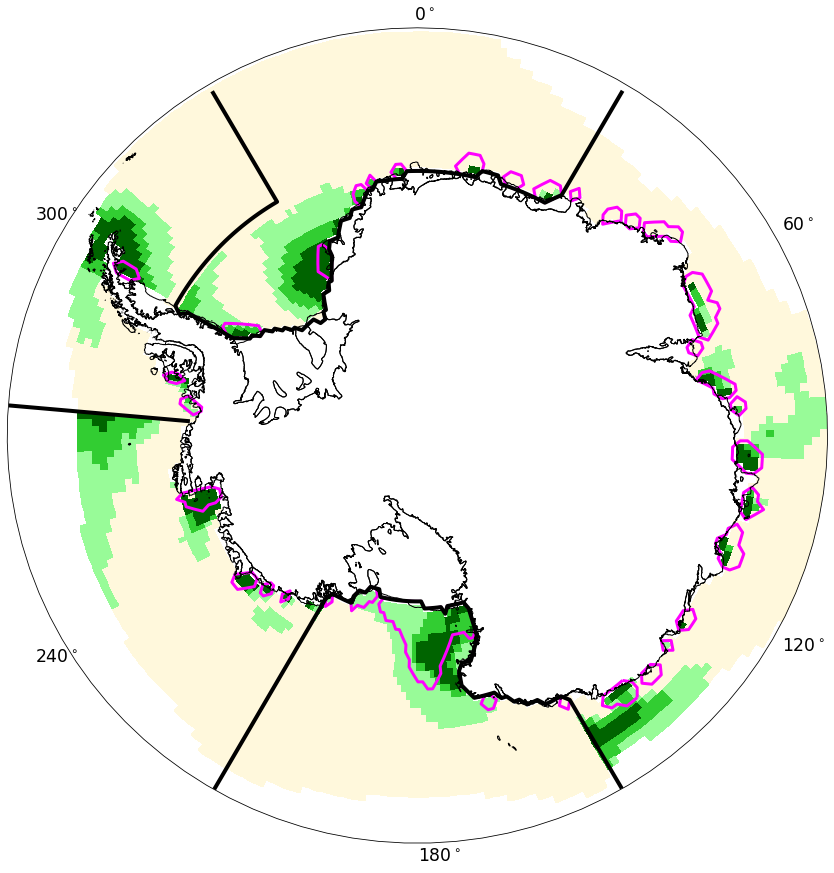

In [27]:
### Plot Regional AEV Index Bins by decade
# set decade to plot
dec = 2030
dec_str = str(dec)
fout = 'Figure_4_AEV_region_bins_'+dec_str
data_plt = bins_all.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(15,15))

### Plot the AEV bins
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
# plot bins
this=ax.pcolormesh(lons,lats,data_plt,
                   vmax = 3, vmin = 0, cmap=cMap_bins,transform=ccrs.PlateCarree())
### Overlay polynyas
poly_data = poly_cesm2le.sel(decades=dec)
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_data.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=3,
                 levels=levels_in_ctr, transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry,ccrs.SouthPolarStereo(),facecolor='none',edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

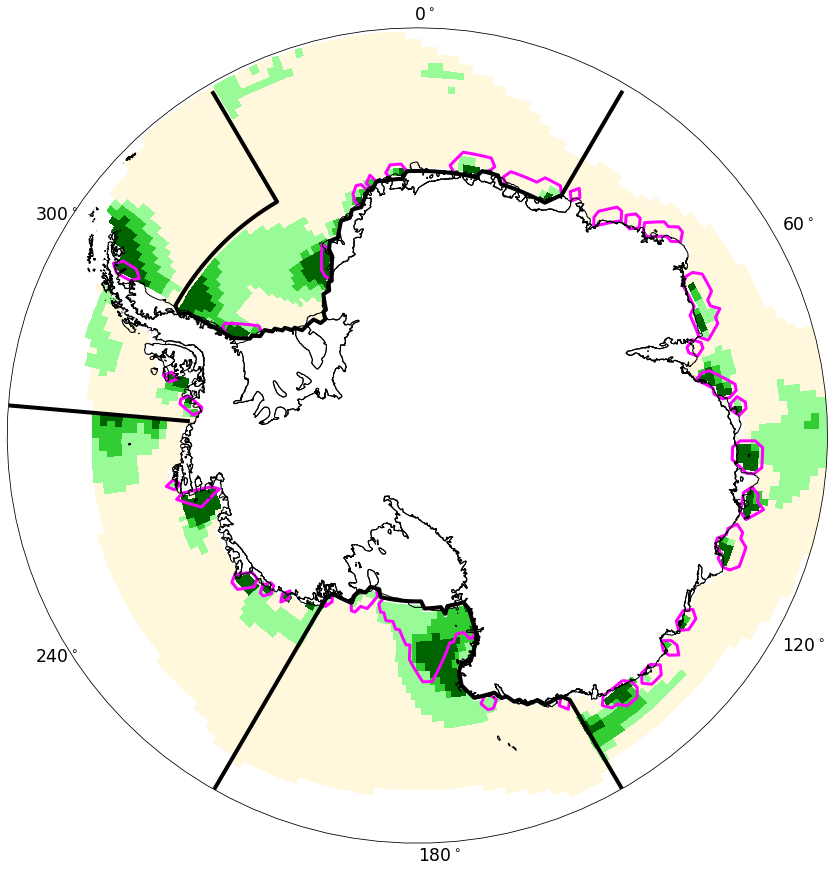

In [28]:
### Plot Regional AEV Index Bins by decade
# set decade to plot
dec = 2060
dec_str = str(dec)
fout = 'Figure_4_AEV_region_bins_'+dec_str
data_plt = bins_all.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(15,15))

### Plot the AEV bins
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
# plot bins
this=ax.pcolormesh(lons,lats,data_plt,
                   vmax = 3, vmin = 0, cmap=cMap_bins,transform=ccrs.PlateCarree())
### Overlay polynyas
poly_data = poly_cesm2le.sel(decades=dec)
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_data.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=3,
                 levels=levels_in_ctr, transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry,ccrs.SouthPolarStereo(),facecolor='none',edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

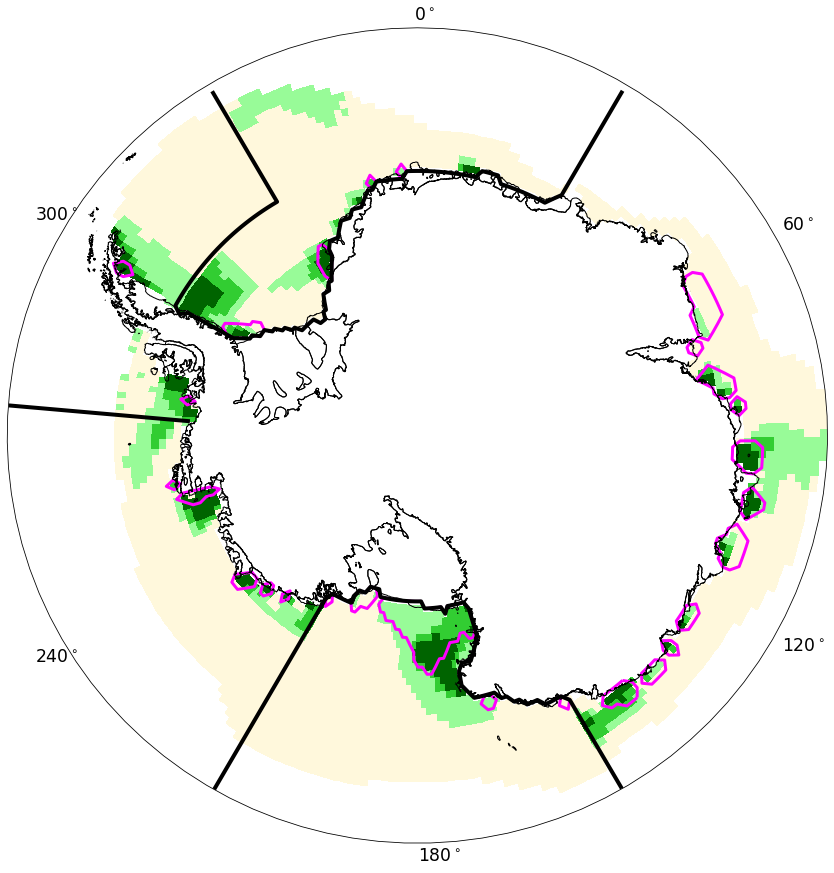

In [29]:
### Plot Regional AEV Index Bins by decade
# set decade to plot
dec = 2090
dec_str = str(dec)
fout = 'Figure_4_AEV_region_bins_'+dec_str
data_plt = bins_all.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(15,15))

### Plot the AEV bins
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
# plot bins
this=ax.pcolormesh(lons,lats,data_plt,
                   vmax = 3, vmin = 0, cmap=cMap_bins,transform=ccrs.PlateCarree())
### Overlay polynyas
poly_data = poly_cesm2le.sel(decades=dec)
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_data.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=3,
                 levels=levels_in_ctr, transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry,ccrs.SouthPolarStereo(),facecolor='none',edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

### Plot AEV bin differences by decade
- 2030, 2060, 2090 MINUS 2000

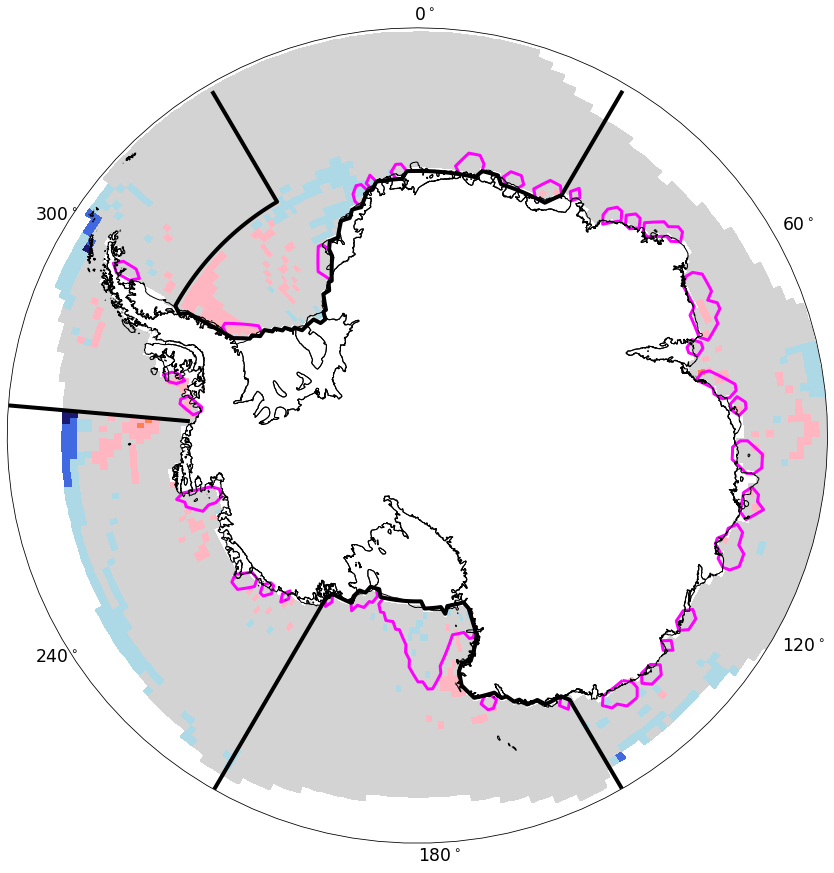

In [30]:
### Plot Regional AEV Index Bins DIFFERENCES (dec - 2000) by decade
# set decade to plot
dec = 2030
dec_str = str(dec)
fout = 'Figure_4_AEV_region_bin_diffs_'+dec_str
data_plt = bins_diff.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(15,15))

### Plot the AEV bins
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
# plot bins
this=ax.pcolormesh(lons,lats,data_plt,
                   vmax = 3, vmin = -3, cmap=cMap_diff,transform=ccrs.PlateCarree())
### Overlay polynyas
poly_data = poly_cesm2le.sel(decades=dec)
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_data.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=3,
                 levels=levels_in_ctr, transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry,ccrs.SouthPolarStereo(),facecolor='none',edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

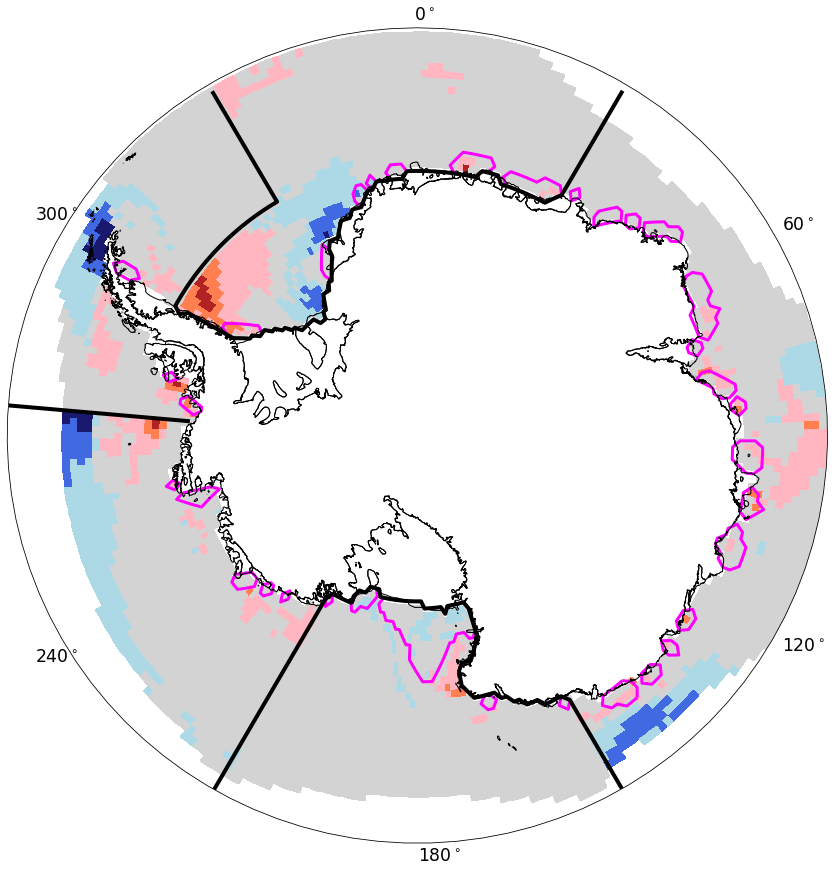

In [31]:
### Plot Regional AEV Index Bins DIFFERENCES (dec - 2000) by decade
# set decade to plot
dec = 2060
dec_str = str(dec)
fout = 'Figure_4_AEV_region_bin_diffs_'+dec_str
data_plt = bins_diff.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(15,15))

### Plot the AEV bins
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
# plot bins
this=ax.pcolormesh(lons,lats,data_plt,
                   vmax = 3, vmin = -3, cmap=cMap_diff,transform=ccrs.PlateCarree())
### Overlay polynyas
poly_data = poly_cesm2le.sel(decades=dec)
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_data.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=3,
                 levels=levels_in_ctr, transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry,ccrs.SouthPolarStereo(),facecolor='none',edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

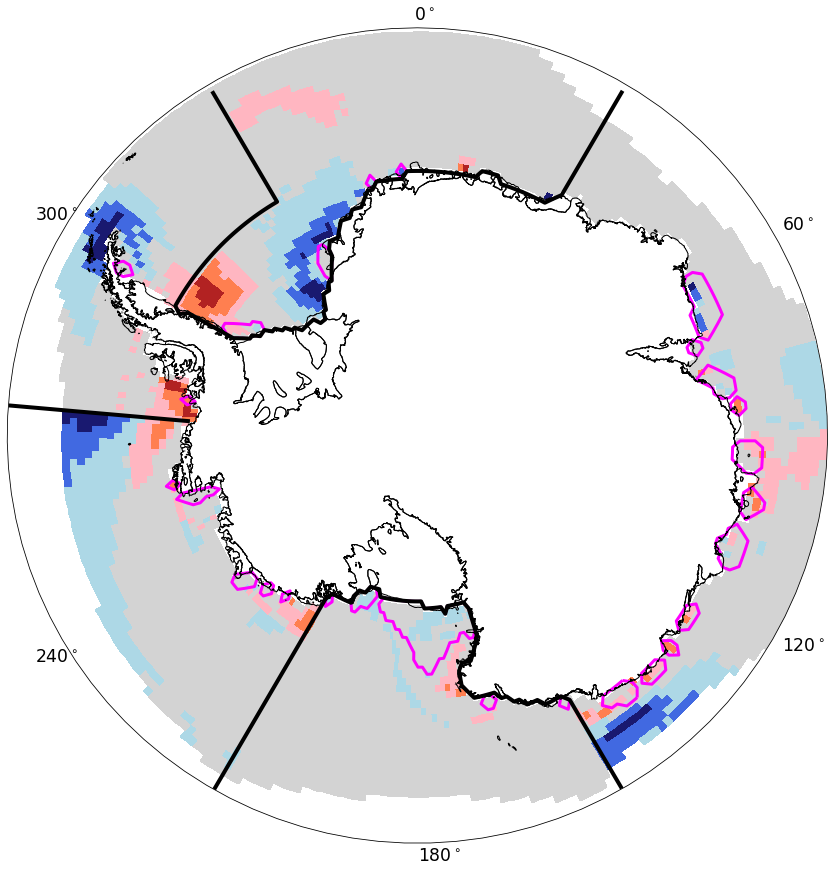

In [32]:
### Plot Regional AEV Index Bins DIFFERENCES (dec - 2000) by decade
# set decade to plot
dec = 2090
dec_str = str(dec)
fout = 'Figure_4_AEV_region_bin_diffs_'+dec_str
data_plt = bins_diff.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(15,15))

### Plot the AEV bins
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
# plot bins
this=ax.pcolormesh(lons,lats,data_plt,
                   vmax = 3, vmin = -3, cmap=cMap_diff,transform=ccrs.PlateCarree())
### Overlay polynyas
poly_data = poly_cesm2le.sel(decades=dec)
lon, lat, field = utils.adjust_pop_grid(lons,lats,poly_data.fillna(0))
this2=ax.contour(lon,lat,field,
                 colors='magenta',linestyles='solid',linewidths=3,
                 levels=levels_in_ctr, transform=ccrs.PlateCarree()) 
### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-59.5, r'180$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-58.0, r'240$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-58.0, r'300$^\circ$', color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry,ccrs.SouthPolarStereo(),facecolor='none',edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)